# Example
In this example, we'll compute climate diagnostics for Woods Hole sea surface temperature (SST) using the ERA5 reanalysis.

In [1]:
import pathlib
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns
import time
import cmocean
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import scipy.signal
import copy

## (optional) remove gridlines from plots
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## Functions

In [2]:
def plot_setup(fig, projection, lon_range, lat_range, xticks=None, yticks=None):
    """Add a subplot to the figure with the given map projection
    and lon/lat range. Returns an Axes object."""

    ## increase resolution for projection
    ## (otherwise lines plotted on surface won't follow curved trajectories)
    projection.threshold /= 1000

    ## Create subplot with given projection
    ax = fig.add_subplot(projection=projection)

    ## Subset to given region
    extent = [*lon_range, *lat_range]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ## draw coastlines
    ax.coastlines(linewidths=0.5)

    ## add tick labels
    if xticks is not None:

        ## add lon/lat labels
        gl = ax.gridlines(
            draw_labels=True,
            linestyle="-",
            alpha=0.1,
            linewidth=0.5,
            color="k",
            zorder=1.05,
        )

        ## specify which axes to label
        gl.top_labels = False
        gl.right_labels = False

        ## specify ticks
        gl.ylocator = mticker.FixedLocator(yticks)
        gl.xlocator = mticker.FixedLocator(xticks)

    return ax


def plot_box_outline(ax, lon_range, lat_range):
    """
    Plot box outlining the specifed lon/lat range on given
    ax object.
    """

    ## get width and height
    height = lat_range[1] - lat_range[0]
    width = lon_range[1] - lon_range[0]

    ## add rectangle to plot
    ax.add_patch(
        mpatches.Rectangle(
            xy=[lon_range[0], lat_range[0]],
            height=height,
            width=width,
            transform=ccrs.PlateCarree(),
            facecolor="none",
            edgecolor="k",
            linewidth=1,
        )
    )

    return ax


def plot_correlation(plot_setup_fn, corr, x, y):
    """
    Make spatial plot of correlation, using the specified
    plot setup function and pre-computed correlation.
    Args:
        - plot_setup_fn: function that returns a fig, ax object
        - corr: xarray with spatial correlation
        - x, y: lon/lat points for plotting
    """

    ## blank canvas to plot on
    fig = plt.figure()

    ## draw background map of Atlantic
    fig, ax = plot_setup_fn(fig)

    ## plot the data
    plot_data = ax.contourf(
        x,
        y,
        corr,
        transform=ccrs.PlateCarree(),
        levels=make_cb_range(1, 0.1),
        extend="both",
        # cmap="cmo.balance",
        cmap="seismic",
    )

    ## create colorbath
    colorbar = fig.colorbar(plot_data, label="Corr.", ticks=[-1, -0.5, 0, 0.5, 1])

    return fig, ax


def make_cb_range(amp, delta):
    """Make colorbar_range for cmo.balance
    Args:
        - 'amp': amplitude of maximum value for colorbar
        - 'delta': increment for colorbar
    """
    return np.concatenate(
        [np.arange(-amp, 0, delta), np.arange(delta, amp + delta, delta)]
    )


def plot_setup_timeseries():
    """
    Create fig, ax objects and label time axis
    """

    ## set up plot
    fig, ax = plt.subplots(figsize=(4, 3))

    ## restrict to last 50 years and label axes
    ax.set_xlim([datetime.date(1970, 1, 1), None])

    ax.set_xticks(
        [
            datetime.date(1979, 1, 1),
            datetime.date(2000, 6, 30),
            datetime.date(2021, 12, 31),
        ]
    )
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    return fig, ax


def spatial_avg(data):
    """function to compute spatial average of data on grid with constant
    longitude/latitude spacing."""

    ## first, compute cosine of latitude (after converting degrees to radians)
    latitude_radians = np.deg2rad(data.latitude)
    cos_lat = np.cos(latitude_radians)

    ## get weighted average using xarray
    avg = data.weighted(weights=cos_lat).mean(["longitude", "latitude"])

    return avg


def get_trend(data, dim="time", deg=1):
    """
    Get trend for an xr.dataarray along specified dimension,
    by fitting polynomial of degree 'deg'.
    """

    ## Get coefficients for best fit
    polyfit_coefs = data.polyfit(dim=dim, deg=deg)["polyfit_coefficients"]

    ## Get best fit line (linear trend in this case)
    trend = xr.polyval(data[dim], polyfit_coefs)

    return trend


def detrend(data, dim="time", deg=1):
    """
    Remove trend of degree 'deg' from data, along dimension 'dim'.
    """

    return data - get_trend(data, dim=dim, deg=deg)


def get_empirical_pdf(x):
    """
    Estimate the "empirical" probability distribution function for the data x.
    In this case the result is a normalized histogram,
    Normalized means that integrating over the histogram yields 1.
    Returns the PDF (normalized histogram) and edges of the histogram bins
    """

    ## compute histogram
    hist, bin_edges = np.histogram(x)

    ## normalize to a probability distribution (PDF)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    pdf = hist / (hist * bin_width).sum()

    return pdf, bin_edges


def get_gaussian_best_fit(x):
    """Get gaussian best fit to data, and evaluate
    probabilities over the range of the data."""

    ## get normal distribution best fit
    gaussian = scipy.stats.norm(loc=x.mean(), scale=x.std())

    ## evaluate over range of data
    amp = np.max(np.abs(x.values))
    x_eval = np.linspace(-amp, amp)
    pdf_eval = gaussian.pdf(x_eval)

    return pdf_eval, x_eval


def swap_longitude_range(data):
    """swap longitude range of xr.DataArray from [0,360) to (-180, 180]"""

    ## copy of longitude coordinate to be modified
    new_longitude = copy.deepcopy(data.longitude.values)

    ## find index where longitude first exceeds 180.
    ## (note: np.argmax returns first instance of "True" in boolean array)
    swap_idx = np.argmax(new_longitude > 180)

    ## relabel values >180
    new_longitude[swap_idx:] = -360 + new_longitude[swap_idx:]

    ## add this coordinate back to the array
    data["longitude"] = new_longitude

    ## "roll" the data to be centered at zero
    data = data.roll({"longitude": -swap_idx}, roll_coords=True)

    return data

### Region-specific functions

```{admonition} To-do: update trimming/plotting functions
When implementing your own example, you may need to trim to a different spatial region. You may also want to adjust the region shown in the spatial plot.

In [3]:
def trim_to_north_atl(data):
    """trim xr.DataArray to North Atlantic region"""

    ## boolean arrays for lon/lat
    lon_in_range = (data.longitude >= -100) & (data.longitude <= 15)
    lat_in_range = (data.latitude >= 0) & (data.latitude <= 70)

    return data.isel(latitude=lat_in_range, longitude=lon_in_range)


def plot_setup_atlantic(fig):
    """Plot Atlantic region"""

    ## adjust figure size
    fig.set_size_inches(5, 3)

    ## specify map projection
    proj = ccrs.Orthographic(central_longitude=-50, central_latitude=40)

    ## get ax object
    ax = plot_setup(
        fig,
        proj,
        lon_range=[-100, 0],
        lat_range=[10, 70],
        xticks=[-90, -45, 0],
        yticks=[0, 35],
    )

    return fig, ax


def plot_setup_woodshole(fig):
    """Plot zoomed-in view of Woods Hole"""

    ## adjust figure size
    fig.set_size_inches(5, 3)

    ## set map projection to orthographic
    proj = ccrs.Orthographic(central_longitude=-67.5, central_latitude=40)

    ## Get ax object based on generic plotting function
    ax = plot_setup(
        fig,
        proj,
        lon_range=[-75, -60],
        lat_range=[35, 45],
        xticks=[-73, -68, -63],
        yticks=[37, 42],
    )

    return fig, ax

## Data loading

### Data-loading functions

In [4]:
def load_era5_from_server(server_fp, lon_range, lat_range):
    """Load ERA5 data from CMIP6 server"""

    ## Filepath to the ERA5 reanalysis
    era5_fp = pathlib.Path("cmip6/data/era5/reanalysis/single-levels/monthly-means")

    ## sea surface temperature (SST) filepaths
    era5_fp_sst = server_fp / era5_fp / pathlib.Path("sea_surface_temperature")

    ## open the data
    data = xr.open_mfdataset(era5_fp_sst.glob("*.nc"))["sst"]

    ## select lon/lat range
    lonlat_idx = dict(longitude=slice(*lon_range), latitude=slice(*lat_range[::-1]))
    data = data.sel(lonlat_idx).compute()

    ## put latitudes in ascending order
    data = data.reindex({"latitude": data["latitude"].values[::-1]})

    return data


def load_era5_from_cloud(lon_range, lat_range):
    """Load ERA5 from Google server"""

    ## open data and get SST
    data = xr.open_zarr(
        "gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr",
        chunks=dict(time=1024),
    )["sea_surface_temperature"]

    ## subset for lon/lat range
    lonlat_idx = dict(longitude=slice(*lon_range), latitude=slice(*lat_range))
    data = data.sel(**lonlat_idx)

    ## load into memory
    data.load()

    ## resample from 6-hourly to monthly
    data = data.resample({"time": "MS"}).mean()

    ## transpose data (consistent with data on server)
    data = data.transpose("time", "latitude", "longitude")

    return data

### Load the data

```{admonition} To-do: update path to data
Update the filepath ```server_fp``` in the code cell below. This is the location of the WHOI CMIP server on your computer (see [server connection setup](../setup/connect_to_server.md) for details).
```

````{warning} CMIP server errors
The CMIP server seems unable to handle multiple users access the same file at once (e.g., during the actual tutorial session). If you get a mysterious error when trying to load data from the server (e.g., ```NetCDF: HDF error```), try loading the data from the cloud instead (i.e., set ```LOAD_FROM_CLOUD = True``` in the code cell below).

In order to load data from Google Cloud storage, you need to install the [```gcsfs``` package](https://gcsfs.readthedocs.io/en/latest/):  
```conda install -c conda-forge gcsfs```, or  
```mamba install -c conda-forge gcsfs```
````

In [5]:
## specify server filepath (only required if loading from server)
SERVER_FP = pathlib.Path("/Volumes")

## specify whether to load data from cloud
LOAD_FROM_CLOUD = False

## specify lon/lat range
kwargs = dict(lon_range=[260, 360], lat_range=[10, 70])

## keep track of time for data loading
t0 = time.time()

## do the data loading
if LOAD_FROM_CLOUD:
    data = load_era5_from_cloud(**kwargs)

else:
    data = load_era5_from_server(SERVER_FP, **kwargs)

## print elapsed time
print(f"{time.time() - t0: .1f} seconds")

 13.9 seconds


Did you get error ```KeyError or OSError: [Errno -101] NetCDF: HDF error```? Go to FAQ page under the resources section...

NOTE: after preventing file locking rewill have to relaunch jupyter from your terminal. Save your changes and close this tab. 

### Plot a sample from the data
if you have not installed cmocean you will need to do so (conda/mamba install -c conda-forge cmocean) or swap lines or use "plasma" instead of cmo.thermal (ie switch which cmap line is commented out)

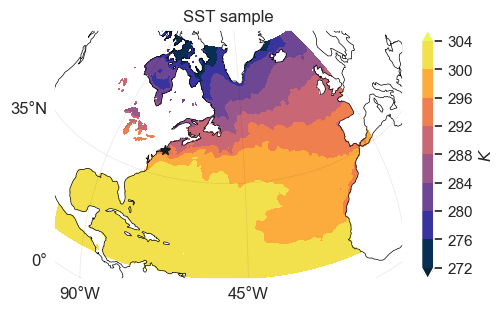

In [6]:
## blank canvas to plot on
fig = plt.figure(layout="constrained")

## draw background map of Atlantic
fig, ax = plot_setup_atlantic(fig)

## plot the data
plot_data = ax.contourf(
    data.longitude,
    data.latitude,
    data.isel(time=-1),
    transform=ccrs.PlateCarree(),
    levels=10,
    extend="both",
    cmap="cmo.thermal",
    # cmap="plasma",
)

## create colorbath
colorbar = fig.colorbar(plot_data, label=r"$K$")

## Mark Woods Hole on map
ax.scatter(
    288.5, 41.5, transform=ccrs.PlateCarree(), marker="*", c="k", s=50, zorder=10
)

## label
ax.set_title(f"SST sample")

## save fig if you would like
# fig.savefig("Your_directory/sst-sample.svg")

plt.show()

## Define an index
Next, let's define the "Woods Hole temperature index", $T_{wh}$ as the temperature averaged near Woods Hole.

```{admonition} To-do: define your own index
E.g., choose a different region.

In [7]:
def compute_T_wh(x):
    """Compute Woods Hole temperature index"""

    ## define lon/lat range for averaging
    ## (note latitude is in descending order in ERA5)
    # region = dict(latitude=slice(44, 39), longitude=slice(-72.5, -66.5))
    region = dict(latitude=slice(39, 44), longitude=slice(287.5, 293.5))

    ## get subset of data inside the box
    data_subset = x.sel(region)

    ## compute spatial average
    return spatial_avg(data_subset)


## do the computation here
idx = compute_T_wh(data)

Let's plot an outline of the region below:

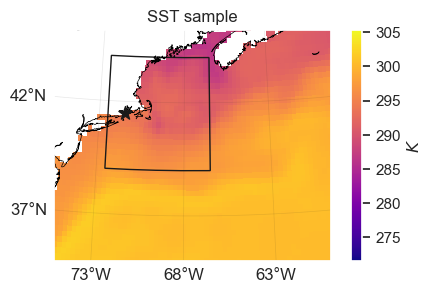

In [8]:
## blank canvas to plot on
fig = plt.figure()

## draw background map of Atlantic
fig, ax = plot_setup_woodshole(fig)

## plot the data
xx, yy = np.meshgrid(data.longitude.values, data.latitude.values)
plot_data = ax.pcolormesh(
    xx,
    yy,
    data.isel(time=-1),
    transform=ccrs.PlateCarree(),
    # cmap="cmo.thermal",
    cmap="plasma",
)

## create colorbar
colorbar = fig.colorbar(plot_data, label=r"$K$")

## Mark Woods Hole on map
ax.scatter(
    288.5, 41.5, transform=ccrs.PlateCarree(), marker="*", c="k", s=100, zorder=10
)

## plot outline of region used to compute index
ax = plot_box_outline(ax, lon_range=[-72.5, -66.5], lat_range=[39, 44])

## label the plot
ax.set_title(f"SST sample")

plt.show()

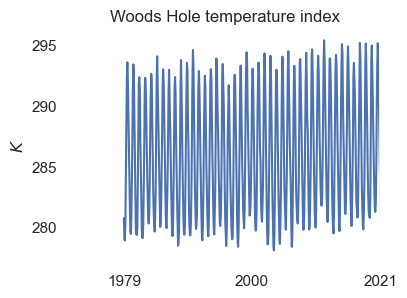

In [9]:
fig, ax = plot_setup_timeseries()

## Plot the data
ax.plot(idx.time, idx)

## label axes
ax.set_title(r"Woods Hole temperature index")
ax.set_ylabel(r"$K$")

plt.show()

## Diagnostics

### Seasonal cycle

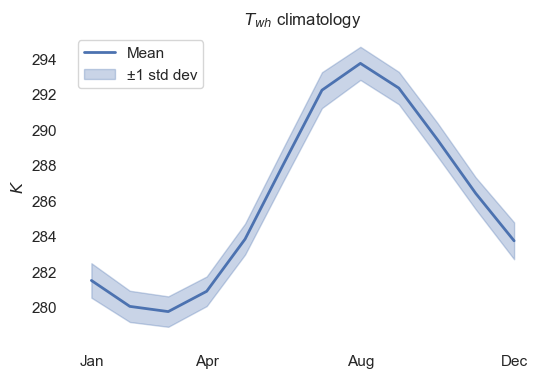

In [10]:
## compute mean and standard deviation
seasonal_mean = idx.groupby("time.month").mean("time")
seasonal_std = idx.groupby("time.month").std("time")

## make the plot
fig, ax = plt.subplots(figsize=(6, 4))

# plot mean
ax.plot(
    seasonal_mean["month"],
    seasonal_mean,
    label="Mean",
    color="C0",
    linestyle="-",
    linewidth=2,
)

# Plot shaded std as band (optional)
ax.fill_between(
    seasonal_mean["month"],
    seasonal_mean - seasonal_std,
    seasonal_mean + seasonal_std,
    color="C0",
    alpha=0.3,
    label="±1 std dev",
)

## add some labels
ax.set_xticks([1, 4, 8, 12], labels=["Jan", "Apr", "Aug", "Dec"])
ax.set_title(r"$T_{wh}$ climatology")
ax.set_ylabel(r"$K$")
ax.legend()

# fig.savefig("your_dir/seasonal-cycle.svg")

plt.show()

### Compute anomalies and linear trend for index

In [11]:
## compute anomalies at gridpoint level, then recompute temperature index
data_anom = data.groupby("time.month") - data.groupby("time.month").mean()
idx_anom = compute_T_wh(data_anom).compute()

## compute linear trend (set deg=2 for quadratic trend)
idx_trend = get_trend(idx_anom, deg=1)

### Next, let's plot the anomalies

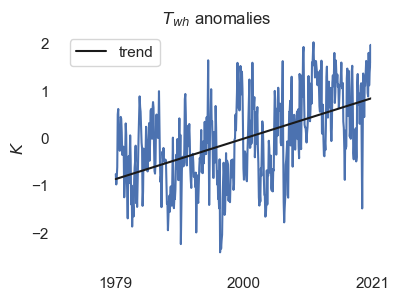

In [12]:
## setup the plot
fig, ax = plot_setup_timeseries()

## plot index
ax.plot(idx_anom.time, idx_anom)

## superimpose trend
ax.plot(idx_trend.time, idx_trend, label="trend", c="k")
ax.legend()

## label plot
ax.set_title(r"$T_{wh}$ anomalies")
ax.set_ylabel(r"$K$")

# fig.savefig("figs/trend.svg")

plt.show()

### Histogram

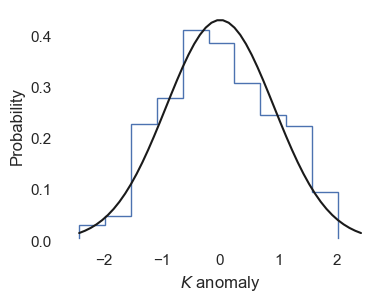

In [13]:
## compute normalized histogram and best-fit Gaussian
pdf, pdf_edges = get_empirical_pdf(idx_anom)
pdf_gauss, pdf_gauss_pts = get_gaussian_best_fit(idx_anom)

#### Plot result
fig, ax = plt.subplots(figsize=(4, 3))

## plot histogram
ax.stairs(values=pdf, edges=pdf_edges)

## plot gaussian
x = np.linspace(-3, 3)
ax.plot(pdf_gauss_pts, pdf_gauss, c="k")

## label
ax.set_xlabel(r"$K$ anomaly")
ax.set_ylabel("Probability")

## save to file
# fig.savefig("figs/histogram.svg")

plt.show()

#### Power spectral density (PSD)

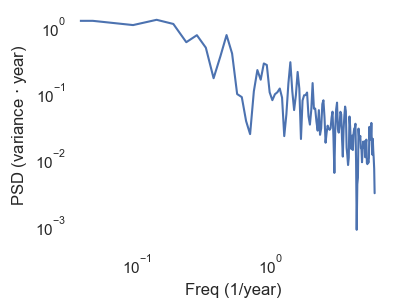

In [14]:
## compute PSD
## 'fs' is sampling frequency (units: samples/year)
freq, psd = scipy.signal.welch(idx_anom.values, fs=12)

## plot result
fig, ax = plt.subplots(figsize=(4, 3))
ax.loglog(freq, psd)
ax.set_xlabel("Freq (1/year)")
ax.set_ylabel(r"PSD (variance $\cdot$ year)")
plt.show()

### Spatial correlation
(between index and spatial data)

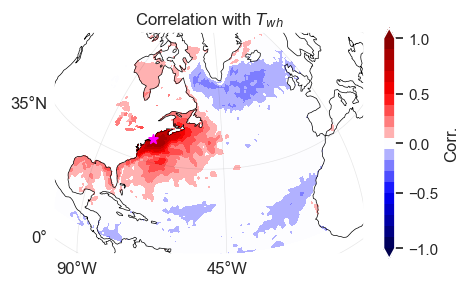

In [15]:
## compute correlation (detrend data first)
corr = xr.corr(detrend(data_anom), detrend(idx_anom), dim="time")

## Make plot
fig, ax = plot_correlation(
    plot_setup_fn=plot_setup_atlantic, corr=corr, x=corr.longitude, y=corr.latitude
)

## Mark Woods Hole on map
ax.scatter(
    288.5, 41.5, transform=ccrs.PlateCarree(), marker="*", c="magenta", s=50, zorder=10
)

## label
ax.set_title(r"Correlation with $T_{wh}$")

## save to file
# fig.savefig("figs/spatial-correlation.svg")

plt.show()